# Entrega Lab8

## Primera part
- Primer hem de contruïr el grafè 
- Després hem de veure com evoluciona l'energia total del sistema al aumentar la garella de punts k per a samplejarl'espai recíproc
- Finalment parlar dels paràmetres que ens parlen de que hem assolit la convergència

## Segona part
- Ara hem de construïr el hexagonal Boron Nitride (hBN)
- Després representar les seves bandes i comparar com ha canviat respecte el grafè

Per a fer aquest exercici necessiaterm:
- Pseudo potenciales del C
- Pseudo potenciales del B
- Pseudo potenciales del N 

El ficher del Carboni estarà en el directori `Inputs/Grapphene`

El ficher del Bor i del Nitrogen en el directori `Inputs/hBN`

In [1]:
#Import the libraries we will be needing
import numpy as np
import sisl
import sisl.viz
import plotly.express as px
from pathlib import Path
import os
import itertools
import matplotlib.pyplot as plt

Ara generem el grafè amb `sisl`

In [2]:
# Create the geometry
graphene = sisl.geom.graphene()

Ara escribim aquesta estructura a un ficher .fdf

In [3]:
inputs_dir = Path("Inputs/Graphene")
graphene.write(inputs_dir / "graphen_geom.fdf")

Ara definim (i creem) el directori on estudiarem l'efecte de variar el k-grid

In [4]:
# Define the root directory for the convergence study for k grid points
root = Path("k_study")
# Create the directory if it doesn't exist
root.mkdir(exist_ok=True)

Ara fem un loop que:
- Crei els directoris per a cada tamany del k-grid
- Copi els ficher d'input (pseudopotencial i estructura)
- Crei un ficher RUN.fdf on s'inclueixi el ficher amb l'estrctura, el tipus de bases per generar les funcions d'ona, el tipus de k-grid que volem generar en cada cas
- Recopili en una llista l'energia total de cada sistema 
- Recopili en una llista el temps de computació de cada simulació

In [7]:
# Set a list with all the k-grid size (in x and y) we want to try
kgrid_points = ['1', '2', '3', '4', '5', '6','7', '8', '9', '12', '15', '18','21', '24']
Es=[]     # Where we will store the total energies of each system
tComp=[]  # Where we will store the Elapsed time

for kgrid_points in kgrid_points:
    # With this part we will create each directory
    k_dir = root / kgrid_points           
    k_dir.mkdir(exist_ok=True)
    
    #print(f"Working on directory with kdrid size of {kgrid_points}") --> for debugging
    
    # With this part we copy the input in each directory
    os.system(f"cp {inputs_dir}/* {k_dir}")
    
    # With this part we create the RUN.fdf file with every part 
    with open(k_dir / 'RUN.fdf', 'w') as f:
        f.write("%include graphen_geom.fdf \n") # Includes the geometry file
        f.write(f"PAO.BasisSize DZP\n")         # Includes the PAO.Basis
        #We now include the kgrid
        f.write(f"%block kgrid.MonkhorstPack \n")
        f.write(f"   {kgrid_points} 0 0  0 \n")
        f.write(f"   0  {kgrid_points}  0 \n")
        f.write(f"   0 0 1  0 \n")
        f.write(f"%endblock kgrid.MonkhorstPack")
    
    # Now we run the simulation
    siesta_path = "/Users/danibedmarromero/anaconda3/envs/siesta/bin/siesta" 
    os.system(f"cd {k_dir}; {siesta_path} RUN.fdf > RUN.out")
    
    # Now we store the energy of the system in the Es list 
    ESystem = sisl.get_sile(k_dir / "RUN.out").read_energy()['total']
    Es.append(ESystem)
    #print(f"Energy of the system= {ESystem} eV")
    
    # Now we store the Elapsed time in the list tComp
    timer =[]
    myfile = open(k_dir / 'RUN.out', 'r')
    myline = myfile.readline()
    while myline:
        if 'Elapsed' in myline:
            timer.append(myline)
        myline = myfile.readline()
    myfile.close()
    
    Timer = timer[0]
    ElTime = float(Timer[39:44:1])
    tComp.append(ElTime)
    
kgrid_points = ['1', '2', '3', '4', '5', '6','7', '8', '9', '12', '15', '18','21','24']
print('Done!')

Gamma-point calculation with interaction between periodic images
Some features might not work optimally:
e.g. DM initialization from atomic data
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed
Job completed


Done!


Job completed


Ara representem com l'energia de cada sistema i el temps de computació d'aquest canvien segons la mida del k-grid:

In [12]:
figure = px.line(
    x=kgrid_points, y=Es,markers=True
).update_layout(
    title="Convergence of energy and its computational cost with k grid points",
    xaxis_title="k grid points in the x and y directions",
    yaxis_title="Energy [eV]"
)

figure.add_scatter(
    x=kgrid_points, y=tComp, yaxis="y2", line_color="red", name=r"Time [s]"
).add_scatter(
    x=kgrid_points, y=Es, yaxis="y1", line_color="blue", name=r"Energy [eV]"
).update_layout(
    yaxis2 = {"side":'right', 'overlaying': 'y', 'title': "Time [s]"}
).update_layout(
    yaxis = {"side":'left',  'title': "Energy [eV]"}
)

figure.show()


## Dicussió
Podem observar com al augmentar la mida del k-grid l'energia total evoluciona cap a un valor constant (308 eV) el cuál tot i augmentar la mida del grid no canvia, això és un molt bon indicador que els resultats han convergit, ja que tot i augmentar la nostra precissió no observem canvis considerables. En aquest cas, podriem dir que a partir d'un k-grid d'entorn a 7x7 en les direccions x i y ja en tenim suficient (fins i tot amb 4 podriem estar satisfets!

Si observem el temps de computació observem una tendència molt peculiar, primer disminueix el temps fins arribar a un mínim i després tornar a augemntar. El segon augment del temps de computació era esperable, ja que un augment de la precissió amb que samplejem l'espai de les k era d'esperar que ens augmentés el cost computacional. Ara bé, que el cost per a simulacions amb poca precissió sigui major a simulacions amb un precissió acceptable (segons la convergència de l'energia) és sorprenent, jo crec que això és degut a que el sistema no pot evolucionar de manera natural amb les condicions donades i, per tant, té un comportament anòmal que és més costòs de simular.

# Segona part

Ara hem de simular el grafè i el hBN per comparar-los

In [25]:
# Create the hBN by modifying the graphen structure
graphene = sisl.geom.graphene()
hBN = graphene.move([0.03, 0, 0], atoms=1)

- https://www.researchgate.net/figure/A-BN-hexagonal-primitive-unit-cell-B-BN-Orthorhombic-primitive-unit-cell-C-BN_fig1_309695675
- https://hal.science/hal-01323899/document

In [26]:
#Write the geometry in a .fdf file
input_dir_hBN = Path("Inputs/hBN")
hBN.write(input_dir_hBN / "hBN_geom.fdf")

input_dir_graphene = Path("Inputs/graphene_study")
graphene.write(input_dir_graphene / "graphene_geom.fdf")

Ara hem de modificar (manualment) el ficher generat, ha que tenim això:

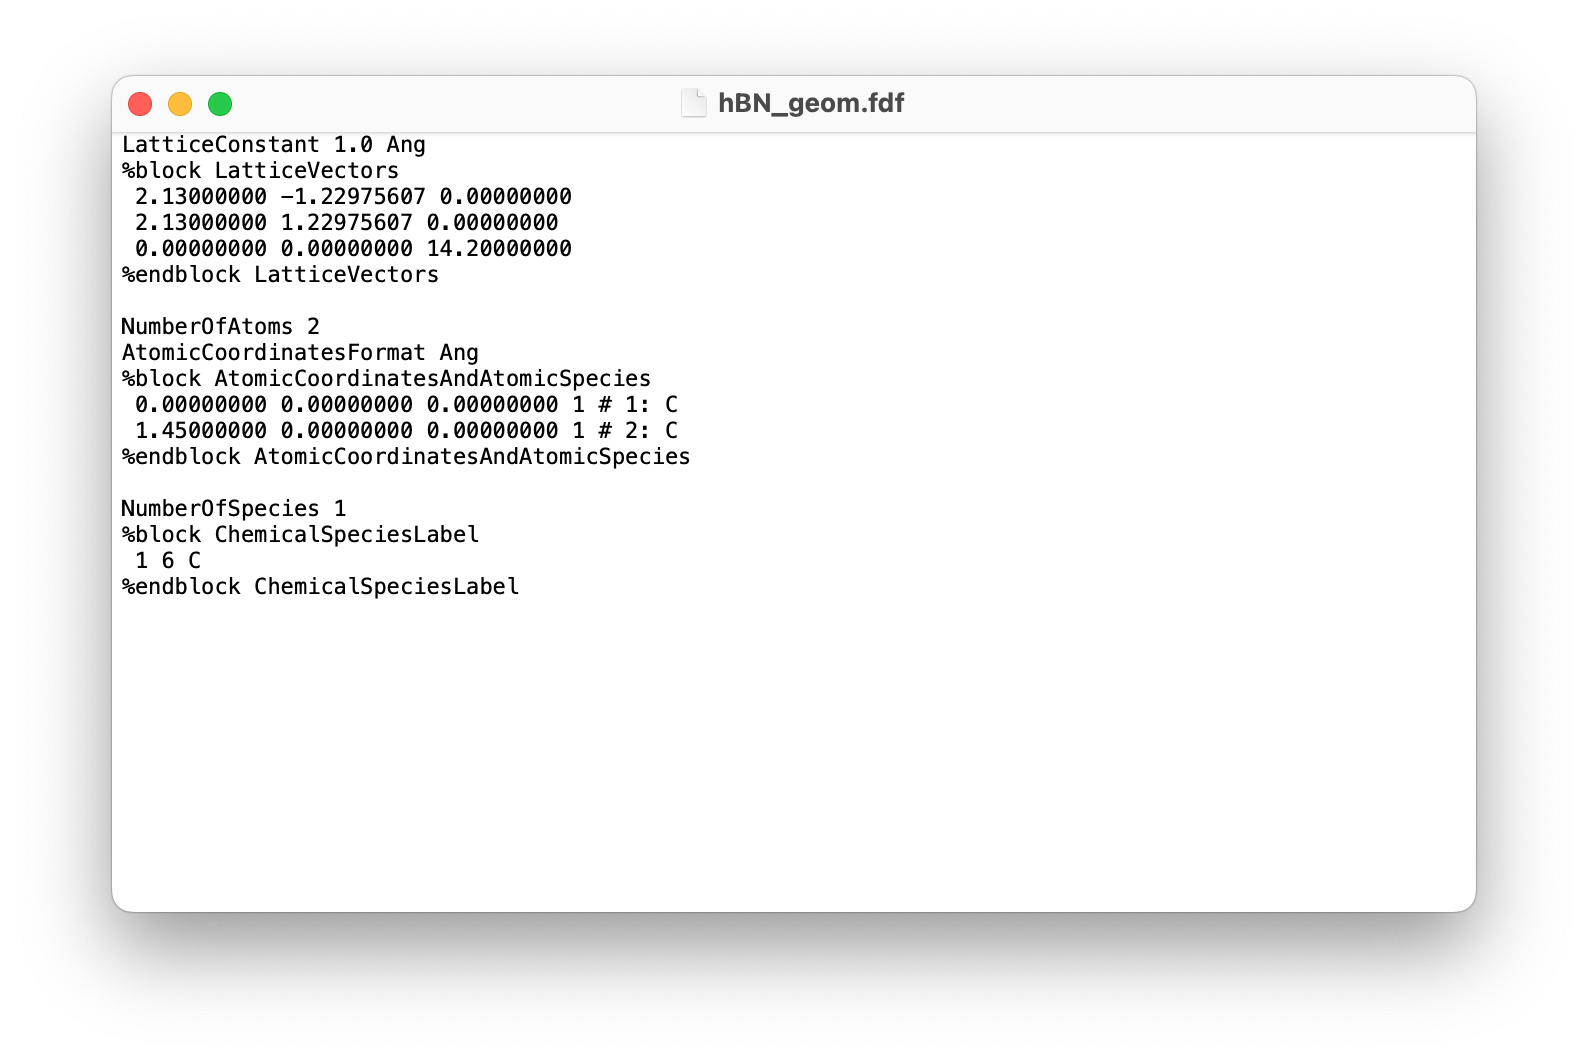

Però volem això:

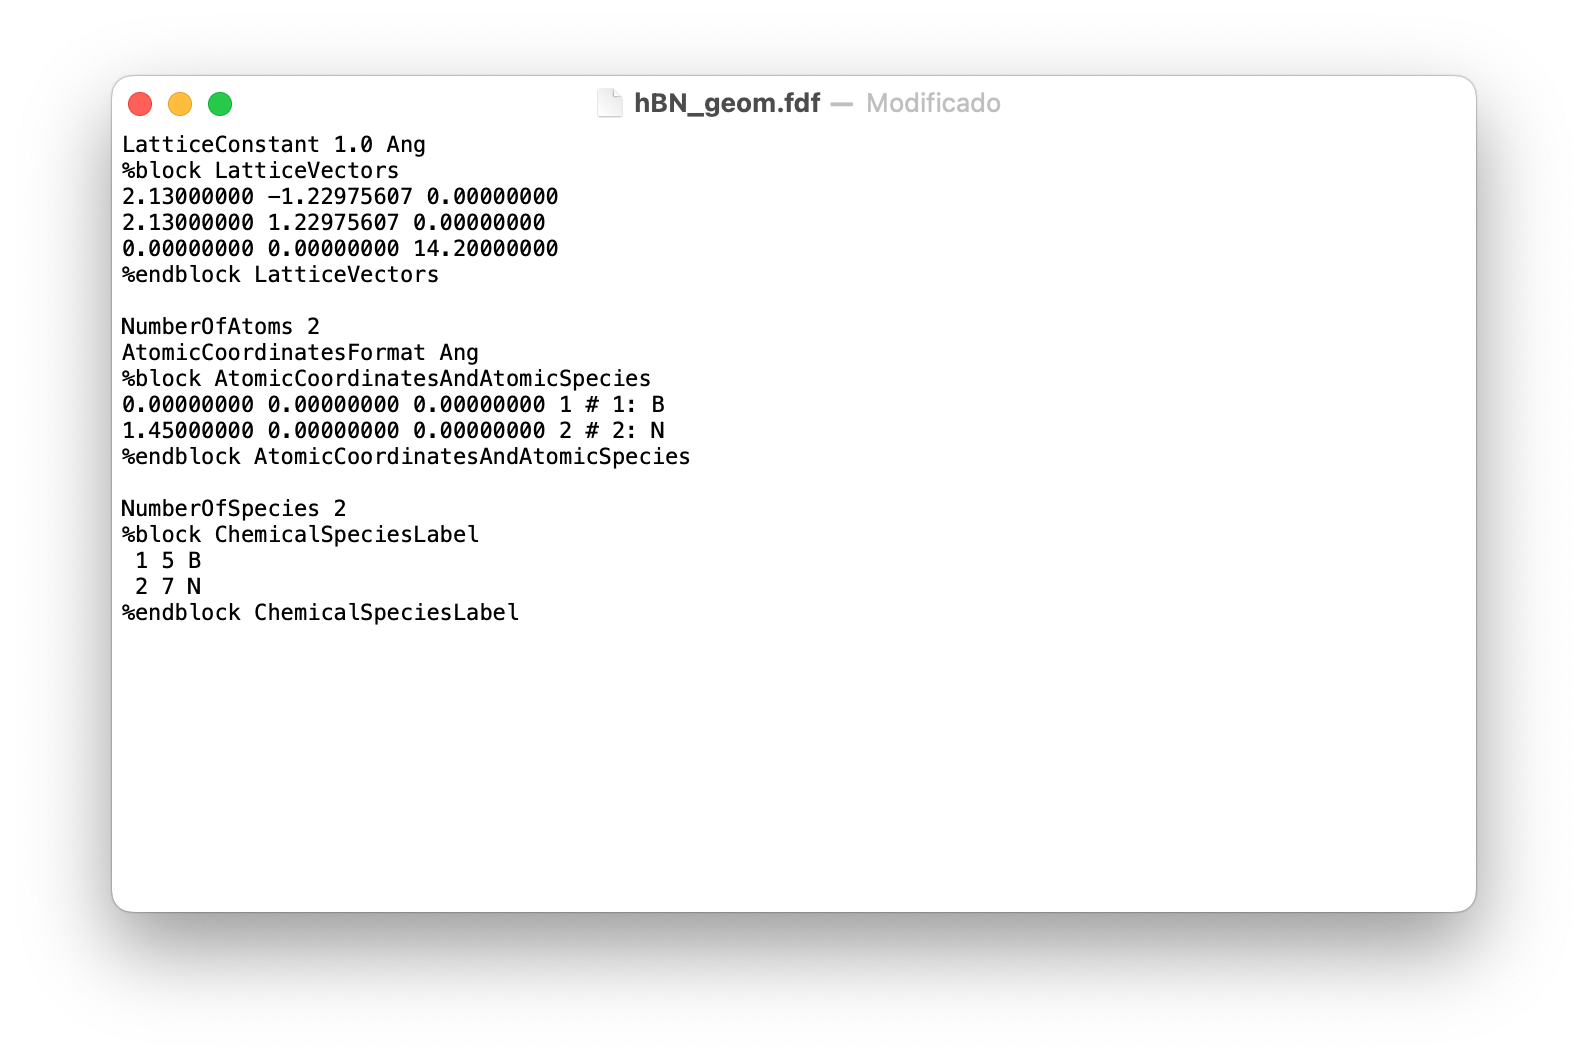

In [13]:
# Define inputs paths
input_dir_hBN = Path("Inputs/hBN")
# Define the root directory for the hBN study
root_hBN = Path("hBN_study")
# Create the directory if it doesn't exist
root_hBN.mkdir(exist_ok=True)

In [38]:
# Define inputs paths
input_dir_graph = Path("Inputs/graphene_study")
# Define the root directory for the hBN study
root_graph = Path("Graphene_study")
# Create the directory if it doesn't exist
root_graph.mkdir(exist_ok=True)

In [14]:
#Copy the hBN input to where we will run the simulation
os.system(f"cp {input_dir_hBN}/* {root_hBN}")
    
#Creamos el fichero Run.fdf  
with open(root_hBN / 'RUN.fdf', 'w') as f:
    # We include the fdf file that contains the geometry, with the %include statement
    # Note the \n, which means "new line" in text files.
    f.write("%include hBN_geom.fdf \n")
    # We now include the basis size input.
    f.write(f"PAO.BasisSize DZP\n")
    #We now include the kgrid
    f.write(f"%block kgrid.MonkhorstPack \n")
    f.write(f"   7 0 0  0 \n")
    f.write(f"   0 7 0  0 \n")
    f.write(f"   0 0 1  0 \n")
    f.write(f"%endblock kgrid.MonkhorstPack\n")
    f.write("SaveRho true\n")
    f.write("TS.HS.Save true\n")

In [39]:
#Copy the hBN input to where we will run the simulation
os.system(f"cp {input_dir_graph}/* {root_graph}")
    
#Creamos el fichero Run.fdf  
with open(root_graph / 'RUN.fdf', 'w') as f:
    # We include the fdf file that contains the geometry, with the %include statement
    # Note the \n, which means "new line" in text files.
    f.write("%include graphene_geom.fdf \n")
    # We now include the basis size input.
    f.write(f"PAO.BasisSize DZP\n")
    #We now include the kgrid
    f.write(f"%block kgrid.MonkhorstPack \n")
    f.write(f"   7 0 0  0 \n")
    f.write(f"   0 7 0  0 \n")
    f.write(f"   0 0 1  0 \n")
    f.write(f"%endblock kgrid.MonkhorstPack\n")
    f.write("SaveRho true\n")
    f.write("TS.HS.Save true\n")

In [15]:
#Run the simulations
siesta_path = "/Users/danibedmarromero/anaconda3/envs/siesta/bin/siesta" 
os.system(f"cd {root_hBN}; {siesta_path} RUN.fdf > RUN.out")

Job completed


0

In [40]:
#Run the simulations
siesta_path = "/Users/danibedmarromero/anaconda3/envs/siesta/bin/siesta" 
os.system(f"cd {root_graph}; {siesta_path} RUN.fdf > RUN.out")

Job completed


0

Proceed with the analysis

In [16]:
RUN_hBN = Path('hBN_study/RUN.FDF')
H_hBN = sisl.get_sile(RUN_hBN).read_hamiltonian()

In [41]:
RUN_graph = Path('Graphene_study/RUN.FDF')
H_graph = sisl.get_sile(RUN_graph).read_hamiltonian()

In [17]:
# We need to define a path of k points
band_struct_hBN = sisl.BandStructure(H_hBN, points=[[0, 0, 0], [2/3, 1/3, 0], [1/2, 0, 0]],
    divisions=100, names=[r"\Gamma", "M", "K"]
)
# Then we can plot the bands
band_struct_hBN.plot()

In [42]:
# We need to define a path of k points
band_struct_graph = sisl.BandStructure(H_graph, points=[[0, 0, 0], [2/3, 1/3, 0], [1/2, 0, 0]],
    divisions=100, names=[r"\Gamma", "M", "K"]
)
# Then we can plot the bands
band_struct_graph.plot()

Amb els plots de l'estructura de banda podem apreciar que la principal diferència  (o al menys amb efectes pràctcis més directes sobre el compost) és que en el hBN trobem un GAP (d'uns 4.5 ev) mentre que en el grafè trobem el seu famòs con de Dirac, el cual li concedeix el seu comportament tan especial

In [18]:
# Get the fatbands plot
fatbands_hBN = band_struct_hBN.plot.fatbands()
# Split the contributions by the n and l quantum numbers
fatbands_hBN.split_groups(on="n+l")

In [43]:
# Get the fatbands plot
fatbands_graph = band_struct_graph.plot.fatbands()
# Split the contributions by the n and l quantum numbers
fatbands_graph.split_groups(on="n+l")

Amb les fatbands podem observar com son els orbitals n=2, l=1 i n=3, l=2 els cuals fan apareixer el conus de Dirac (en especial l'orbital n=2, l=1). Aquests mateixos orbitals son els que contribueixen a les bandes que formen el GAP en el hBN

In [19]:
# Get the PDOS plot
pdos_plot_hBN = H_hBN.plot.pdos(
    kgrid=[90,90,1], nE=1000, Erange=[-10, 10],
    distribution={"method": "gaussian", "smearing": 0.1}
)

# Split the contributions by the n and l quantum numbers
pdos_plot_hBN.split_DOS(on="n+l", name="Atom $atoms")

In [44]:
# Get the PDOS plot
pdos_plot_graph = H_graph.plot.pdos(
    kgrid=[90,90,1], nE=1000, Erange=[-10, 10],
    distribution={"method": "gaussian", "smearing": 0.1}
)

# Split the contributions by the n and l quantum numbers
pdos_plot_graph.split_DOS(on="n+l", name="Atom $atoms")

Amb els plots de la pDOS és molt fàcil veure com en el grafè tenim orbitals (els p) que contribueixen a la densitat d'estats a on en el hBN tenim un GAP

In [22]:
rho_hBN = sisl.get_sile(RUN_hBN).read_grid("RHO")

In [23]:
rho_hBN.plot(axes="xy", plot_geom=True)

In [46]:
rho_graph = sisl.get_sile(RUN_graph).read_grid("RHO")

In [47]:
rho_graph.plot(axes="xy", plot_geom=True)

Podem apreciar com la densitat electrònica està distribuida de manera diferent, ja que, tot i que en els centes dels hexàgons és on es situa la densitat de càrrega més negativa, en el grafè tenim molta més densitat de càrrega sobre els enllaços (gràcies als enllaços pi), mentre que en el hBN la densitat de càrrega està totalment localitzada sobre els àtoms de Nitrogen, això és degut a que els enllaços tenen un fort caràcter donor-acceptor, ja que el Nitrogen és molt més electronegatiu que el Bor